In [2]:
import os
def EXIT_NOTEBOOK(): os._exit(00)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import torch 
from torch import nn
import torch.nn.functional as func
import seaborn as sns

# sns.set_theme()
torch.set_default_dtype(torch.float64)
plt.rcParams['text.usetex'] = True

In [ ]:
import sys; sys.path.insert(1, '../')
from SIQLib.trainNN import *
from SIQLib.Sample import *

In [4]:
class System(object):
    def __init__(self, dim, xrange=[-2, 2], yrange=[-1.5, 1.5], zrange=[-1.5, 1.5]): 
        self.dim    = dim
        self.xrange = xrange
        self.yrange = yrange
        self.zrange = zrange
    def get_force(self,X,rho=1.): 
        if np.size(X.shape)==2:
            b       = np.zeros(dtype=np.float64,shape=X.shape)
            b[:,0]  = -2*(X[:,0]**3-X[:,0])-rho*np.sum(X[:,1:],axis=-1)
            b[:,1:] = -X[:,1:]+2*rho*np.reshape(X[:,0]**3-X[:,0],[-1,1])
        else:
            b     = np.zeros(dtype=np.float64,shape=(self.dim,))
            b[0]  = -2*(X[0]**3-X[0])-rho*np.sum(X[1:])
            b[1:] = -X[1:] + 2*rho*(X[0]**3-X[0])
        return b
dim = 3
SYS = System(dim=dim)

# Generate trajectory data

In [8]:
dim    = 3
a,b    = 0,0
center = np.hstack([[a,b],[0]*(dim-2)])
ll     = np.array([2,1.5,1.5])

N      = 5000     #2000
dt     = 0.01     #0.01
T      = dt*500   
m      = 10       #10
r      = 0.1      #.1
print('No. of trajectories:',N,' dt:',dt,' T:',T,' m:',m,' r:',r)

No. of trajectories: 5000  dt: 0.01  T: 5.0  m: 10  r: 0.1


In [19]:
def sample_initial(n,ll,center=[0]*dim):
    X = np.random.uniform(-1,1,(n,dim))*ll + center
    if n==1: X = X[0]
    return X

ini  = sample_initial(N,ll)
X0X1 = perform_ode(ini,SYS.get_force,T,dt,m,RK4,num_steps=5,mode="X0X1")
print('X0X1 shape:',X0X1.shape)
print('Number of total data points: %.2e' % (X0X1.shape[0]*X0X1.shape[1]*X0X1.shape[2]))

M = X0X1.shape[1]
Xtrain_0,Xtrain_1, Xtest_0,Xtest_1 = split_train_test(X0X1,N,dim)
print(Xtrain_0.shape, Xtest_0.shape)
print()

Xtrain_hat  = get_Xhat(np.vstack([Xtrain_0,Xtrain_1]),r,dim=dim)
Xtest_hat   = get_Xhat(np.vstack([Xtest_0, Xtest_1]), r,dim=dim)
print(Xtrain_hat.shape,Xtest_hat.shape)
print('Number of total rep. points: %d' % (Xtrain_hat.shape[0]+Xtest_hat.shape[0]))

  0%|          | 0/500 [00:00<?, ?it/s]

X0X1 shape: (5000, 50, 2, 3)
Number of total data points: 5.00e+05
(175000, 3) (75000, 3)

(8265, 3) (5204, 3)
Number of total rep. points: 13469


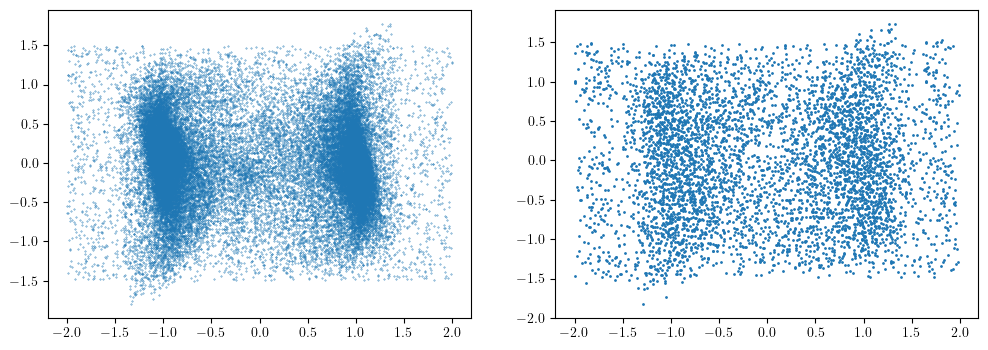

In [20]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].scatter(Xtrain_0[:,0],Xtrain_0[:,1],s=.1)
ax[1].scatter(Xtest_hat[:,0],Xtest_hat[:,1],s=1)
plt.show()

# Make torch data and set the model

In [21]:
data_train = [np.hstack([Xtrain_0,Xtrain_1]),Xtrain_hat]
data_test  = [np.hstack([Xtest_0,Xtest_1]),  Xtest_hat]

In [22]:
model_V = FCNN(input_dim=dim,output_dim=1,  num_hidden=3,hidden_dim=50,act=tanh).cuda()
model_g = FCNN(input_dim=dim,output_dim=dim,num_hidden=3,hidden_dim=50,act=tanh).cuda()
model   = SDE_model(model_V=model_V,model_g=model_g,dim=dim).cuda();
SOL     = Solver(model)

In [24]:
# set mu and sigma
model.mu.data    = torch.tensor(np.mean(data_train[0][:,:dim],axis=0)).cuda()
model.sigma.data = torch.tensor(np.std(data_train[0][:,:dim],axis=0)).cuda()

# set coef_V and coef_g
X0,X1,_ = data_train[0][:,:dim],data_train[0][:,dim:],data_train[1]
f_true  = (X1-X0)/dt
V,dV    = model.get_V_dV(X0)
g       = model.get_g(X0)
f_norm  = np.linalg.norm(f_true,axis=-1)
f_norm  = torch.tensor(f_norm).cuda()
dV_norm = torch.norm(dV,dim=-1)
g_norm  = torch.norm(g,dim=-1)
model.coef_V.data = (model.coef_V*torch.sum(dV_norm*f_norm)/torch.sum(dV_norm*dV_norm)).clone().detach()
model.coef_g.data = (model.coef_g*torch.sum(g_norm*f_norm)/torch.sum(g_norm*g_norm)).clone().detach()

print(model.mu,model.sigma,model.coef_V,model.coef_g)
torch.save(model.state_dict(), 'saved_models/A1')
torch.cuda.empty_cache()

Parameter containing:
tensor([-0.0239, -0.0048,  0.0018], device='cuda:0') Parameter containing:
tensor([0.9898, 0.2746, 0.2738], device='cuda:0') Parameter containing:
tensor(0.0786, device='cuda:0') Parameter containing:
tensor(1.4387, device='cuda:0')


# Set the loss

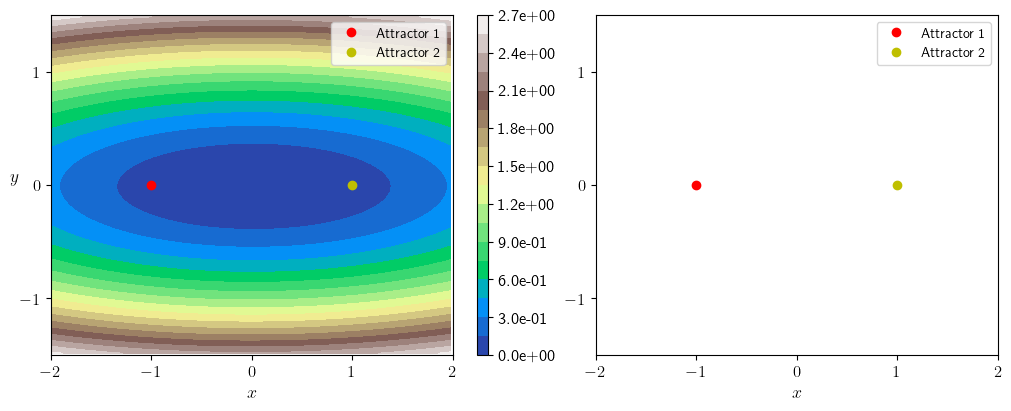

In [25]:
def get_cos_angle(dV,g,delta_2=.1):
    tmp0 = torch.sum(dV*g,axis=-1)
    tmp  = torch.sum(dV**2,axis=-1)*torch.sum(g**2,axis=-1)
    condition = torch.greater(tmp0,0)
    return torch.mean( torch.where(condition, 
                                tmp0**2/tmp, 
                        delta_2*tmp0**2/tmp) )
def get_loss(model,data,h=dt,lbd=1.):

    X0,X1,Xhat = data[0][:,:dim],data[0][:,dim:],data[1]
    X0 = torch.tensor(X0,requires_grad=True).cuda()
    X1 = torch.tensor(X1).cuda()

    _,dV = model.get_V_dV(X0)
    g    = model.get_g(X0)
    f    = -dV+g
    X1_NN = X0 + f*h/2
    
    _,dV = model.get_V_dV(X1_NN)
    g    = model.get_g(X1_NN)
    f    = -dV+g
    X1_NN = X0 + f*h
    
    diff = (X1_NN-X1)/h
        
    dyn_loss = torch.mean( torch.sum(diff**2,axis=-1) )

    V,dV = model.get_V_dV(Xhat)
    g    = model.get_g(Xhat)
    orth_loss = get_cos_angle(dV,g)
    return dyn_loss, orth_loss, dyn_loss+lbd*orth_loss    

def plot_model(model,cmap='terrain',max_V = 10):
    
    xx     = np.linspace(SYS.xrange[0],SYS.xrange[1],100)
    yy     = np.linspace(SYS.yrange[0],SYS.yrange[1],100)
    xx,yy  = (xx[:-1]+xx[1:])/2,(yy[:-1]+yy[1:])/2
    XX,YY  = np.meshgrid(xx,yy)
    X_u    = np.concatenate([XX[:,:,None],YY[:,:,None]],axis=-1).reshape(-1,2)
    X_u    = np.hstack([X_u,[[0]]*len(X_u)])
    
    V_NN  = model.get_V_np(X_u).reshape(XX.shape)
    V_NN_min = V_NN.min()
    V_NN  = V_NN-V_NN_min

    fig, ax    = plt.subplots(1,2,figsize=(10,4),constrained_layout=True)
    c      = ax[0].contourf(XX,YY,np.minimum(V_NN,max_V),25,cmap=cmap)
    cbar   = fig.colorbar(c,ax=ax[0],format='%.1e',aspect=30)
    cbar.ax.tick_params(labelsize=12)
    
    for k in range(2):
        ax[k].set_xlim(SYS.xrange)
        ax[k].set_ylim(SYS.yrange)
        ax[k].set_xlabel(r'$x$', fontsize=13)
        if k==0: ax[k].set_ylabel(r'$y$', fontsize=13, rotation=1)
        ax[k].plot(-1 , 0,'ro',label='Attractor 1')
        ax[k].plot(1,   0,'yo',label='Attractor 2')
        ax[k].set_xticks([-2,-1,0,1,2])
        ax[k].set_yticks([-1,0,1])
        ax[k].legend(fontsize=10,loc='upper right')

    for i in range(len(ax)): 
        ax[i].tick_params(axis="both", labelsize=12)
    plt.show()
plot_model(model)

# Predicting the dynamics

In [26]:
def rL2(x,y): 
    x = np.reshape(x,(len(x),-1))
    y = np.reshape(y,(len(y),-1))
    return np.sqrt( np.sum((x-y)**2,axis=-1).mean()/np.sum(x**2,axis=-1).mean() )
def get_fNN(X,model=model):
    X    = torch.tensor(X,requires_grad=True).cuda()
    _,dV = model.get_V_dV(X)
    g    = model.get_g(X)
    f    = -dV+g
    return f.cpu().data.numpy()
def get_U(X): return X[:,0]**4-2*X[:,0]**2+1+X[:,1]**2+X[:,2]**2
def get_U_NN(X): return 2*model.get_V_np(X)
def get_V_True(X): return get_U(X)/2

X_error = sample_initial(int(1e5),ll) # 1
X_error = [] # 2
for xx in np.linspace(SYS.xrange[0],SYS.xrange[1],100):
    for yy in np.linspace(SYS.yrange[0],SYS.yrange[1],100):
        for zz in np.linspace(SYS.zrange[0],SYS.zrange[1],100):
            X_error.append([xx,yy,zz])
X_error = np.vstack(X_error)
def error_U(model): 
    U    = get_U(X_error)
    U_NN = 2*model.get_V_np(X_error)
    U_NN = U_NN-U_NN.min()
    return rL2(U,U_NN)

print(error_U(model))
torch.cuda.empty_cache()

0.5882513491958065


(200, 50, 3) 200 trajs:  8.97e-01 +- 3.99e-01 


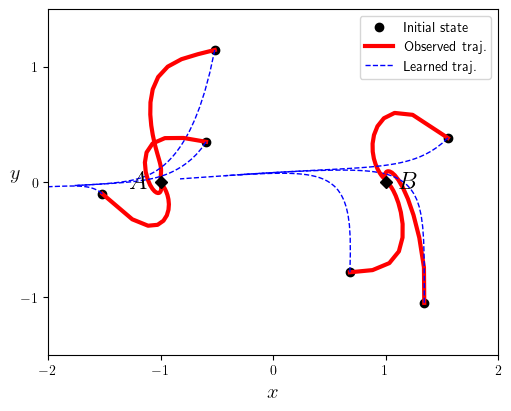

In [33]:
Int_Pars = {}
Int_Pars['dt'] = 1e-2; Int_Pars['T'] = int(5); Int_Pars['m'] = 10; Int_Pars['integrator']=RK2;

X0 = sample_initial(200,ll)

def Prediction_Model(model,X0=X0,ax=None,Int_Pars=Int_Pars,get_f1=SYS.get_force,figname=None):
    def get_f(X,model=model):
        X    = torch.tensor(X,requires_grad=True).cuda()
        _,dV = model.get_V_dV(X)
        g    = model.get_g(X)
        f    = -dV+g
        return f.cpu().data.numpy()
    dt,T,m,integrator = Int_Pars['dt'],Int_Pars['T'],Int_Pars['m'],Int_Pars['integrator']
    exact_traj = perform_ode(X0,get_f1,T,dt,m,integrator=RK4,num_steps=5,mode='X0',use_tqdm=False)
    learned_traj  = perform_ode(X0,get_f,T,dt,m,integrator,mode='X0',use_tqdm=False)
    errors = []
    for k in range(len(exact_traj)):
        errors.append(rL2(exact_traj[k],learned_traj[k]))
    print(learned_traj.shape,'%d trajs:  %.2e +- %.2e '%(len(learned_traj),np.mean(errors),np.std(errors)))

    if ax==None: fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=100,constrained_layout=True)
    id1 = np.argmin(np.linalg.norm(learned_traj[:,0,:2]-[-0.5,1.2],axis=-1))
    id2 = np.argmin(np.linalg.norm(learned_traj[:,0,:2]-[-1.5,0],axis=-1))
    id3 = np.argmin(np.linalg.norm(learned_traj[:,0,:2]-[-.5,.5],axis=-1))
    id4 = np.argmin(np.linalg.norm(learned_traj[:,0,:2]-[0.5,-0.8],axis=-1))
    id5 = np.argmin(np.linalg.norm(learned_traj[:,0,:2]-[1.1,-1],axis=-1))
    id6 = np.argmin(np.linalg.norm(learned_traj[:,0,:2]-[1.5,0.3],axis=-1))
    
    ax.plot(learned_traj[[id1,id2,id3,id4,id5,id6],0][:,0], learned_traj[[id1,id2,id3,id4,id5,id6],0][:,1],'ko',
            markersize=6,label='Initial state')
    for kk,k in enumerate([id1,id2,id3,id4,id5,id6]):
        
        if kk==0: label = 'Observed traj.'
        else: label = None
        ax.plot(exact_traj[k,:,0],exact_traj[k,:,1],'r-',lw=3,label=label)
        
        if kk==0: label = 'Learned traj.'
        else: label = None 
        ax.plot(learned_traj[k,:,0],learned_traj[k,:,1],'b--',lw=1,label=label)
        
    ax.set_xlim(SYS.xrange)
    ax.set_ylim(SYS.yrange)
    ax.set_xlabel(r'$x$', fontsize=15)
    ax.set_ylabel(r'$y$', fontsize=15, rotation=1)
    ax.text(-1.2,0,r'$A$',fontsize=18,ha='center', va='center')
    ax.text(1.2,0,r'$B$',fontsize=18,ha='center', va='center')
    ax.plot(-1 , 0,'kD')
    ax.plot(1,   0,'kD')
    ax.set_xticks([-2,-1,0,1,2])
    ax.set_yticks([-1,0,1])
    ax.tick_params(axis="both", labelsize=10)
    ax.legend(fontsize=10)
    if figname is not None: plt.savefig(figname,dpi=300,bbox_inches='tight')
    if ax is None: plt.show()

Prediction_Model(model,X0)
torch.cuda.empty_cache()

# Train the NNs

10
Parameter containing:
tensor([-0.0239, -0.0048,  0.0018], device='cuda:0') Parameter containing:
tensor([0.9898, 0.2746, 0.2738], device='cuda:0') Parameter containing:
tensor(0.0786, device='cuda:0') Parameter containing:
tensor(1.4387, device='cuda:0')


  0%|          | 0/150001 [00:00<?, ?it/s]

 0k, Loss: 1.38129 0.06682, 1.33070 0.06814, E(QP): 0.5883
 5k, Loss: 2.74e-03 2.54e-04, 2.77e-03 3.09e-04, E(QP): 0.0419
10k, Loss: 1.62e-03 1.51e-04, 1.66e-03 1.89e-04, E(QP): 0.0260
15k, Loss: 3.29e-03 2.54e-04, 3.33e-03 3.14e-04, E(QP): 0.0320
20k, Loss: 1.22e-03 1.62e-04, 1.28e-03 1.25e-04, E(QP): 0.0202
25k, Loss: 3.52e-03 2.54e-04, 3.56e-03 2.83e-04, E(QP): 0.0251
30k, Loss: 1.30e-03 1.99e-04, 1.34e-03 2.42e-04, E(QP): 0.0182
35k, Loss: 4.08e-04 2.87e-05, 4.30e-04 4.25e-05, E(QP): 0.0166
40k, Loss: 1.84e-04 2.12e-05, 2.03e-04 3.34e-05, E(QP): 0.0115
45k, Loss: 6.11e-05 4.78e-06, 8.20e-05 1.01e-05, E(QP): 0.0082
50k, Loss: 6.31e-05 5.15e-06, 7.93e-05 9.60e-06, E(QP): 0.0078
55k, Loss: 4.67e-05 3.23e-06, 6.48e-05 7.52e-06, E(QP): 0.0071
60k, Loss: 3.41e-05 2.04e-06, 5.01e-05 3.97e-06, E(QP): 0.0068
65k, Loss: 3.12e-05 2.35e-06, 4.43e-05 3.90e-06, E(QP): 0.0063
70k, Loss: 2.76e-05 1.78e-06, 4.00e-05 3.27e-06, E(QP): 0.0062
75k, Loss: 2.30e-05 1.50e-06, 3.37e-05 2.17e-06, E(QP): 0.0

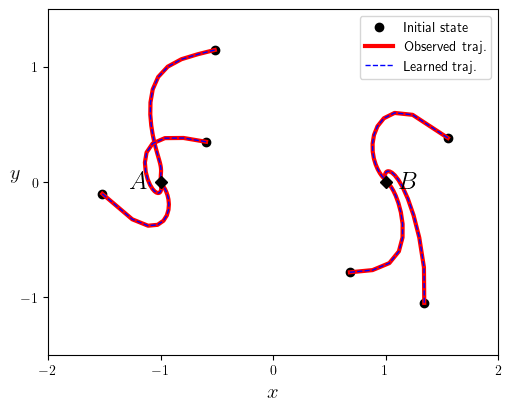

In [35]:
for lbd in [10]:
    print(lbd)
    get_loss.__defaults__ = (get_loss.__defaults__[0],lbd);
    model.load_state_dict(torch.load("saved_models/A1"))
    print(model.mu,model.sigma,model.coef_V,model.coef_g)
    optimizer = torch.optim.Adam(model.parameters(), lr=torch.tensor(0.005).cuda())
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95**(1/1000))
    _loss_step = SOL.train_model(data_train=data_train,data_test=data_test,
                                 get_loss=get_loss,optimizer=optimizer,scheduler=scheduler,
                                 n_steps=int(1.5e5+1),batch_size=5000,n_show_loss=5000,use_tqdm=True,
                                 error_model=error_U)
    
    print(error_U(model))
    torch.cuda.empty_cache()
    Prediction_Model(model)

In [38]:
torch.save([data_train,data_test,X0X1],'data_ex1')
torch.save(model.state_dict(), "saved_models/model_ex1")